In [1]:
import copy
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
class EncoderDecoder(nn.Module):
    """标准的Encoder-Decoder架构"""
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed   # 源序列embedding
        self.tgt_embed = tgt_embed   # 目标序列embedding
        self.generator = generator   # 生成目标单词的概率
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "接收和处理原序列,目标序列,以及他们的mask"
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


class Generator(nn.Module):
    """定义标准的linear+softmax生成步骤"""
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


# Encoder部分
def clones(module, N):
    "产生N个相同的层"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    """N层堆叠的Encoder"""
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "每层layer依次通过输入序列与mask"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class LayerNorm(nn.Module):
    """构造一个layernorm模块"""
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        "Norm"
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    """Add+Norm"""
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "add norm"
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    """Encoder分为两层Self-Attn和Feed Forward"""
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Self-Attn和Feed Forward"
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


# Decoder部分
class Decoder(nn.Module):
    """带mask功能的通用Decoder结构"""
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


class DecoderLayer(nn.Module):
    """Decoder is made of self-attn, src-attn, and feed forward"""
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "将decoder的三个Sublayer串联起来"
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

def subsequent_mask(size):
    """
    mask后续的位置，返回[size, size]尺寸下三角Tensor
    对角线及其左下角全是1，右上角全是0
    """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


# Attention
def attention(query, key, value, mask=None, dropout=None):
    "计算Attention即点乘V"
    d_k = query.size(-1)
    # [B, h, L, L]
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        """
        实现MultiHeadedAttention。
           输入的q，k，v是形状 [batch, L, d_model]。
           输出的x 的形状同上。
        """
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) 这一步qkv变化:[batch, L, d_model] ->[batch, h, L, d_model/h] 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                   for l, x in zip(self.linears, (query, key, value))]
        
        # 2) 计算注意力attn 得到attn*v 与attn
        # qkv :[batch, h, L, d_model/h] -->x:[b, h, L, d_model/h], attn[b, h, L, L]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) 上一步的结果合并在一起还原成原始输入序列的形状
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        # 最后再过一个线性层
        return self.linears[-1](x)

    
# Position-wise Feed-Forward Networks
class PositionwiseFeedForward(nn.Module):
    "实现FFN函数"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Embeddings
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model  #表示embedding的维度

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


# Positional Encoding
class PositionalEncoding(nn.Module):
    "实现PE功能"
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)    # 偶数列
        pe[:, 1::2] = torch.cos(position * div_term)    # 奇数列
        pe = pe.unsqueeze(0)           # [1, max_len, d_model]
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)


# 定义一个接受超参数并生成完整模型的函数
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "根据输入的超参数构建一个模型"
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
     
    # 使用xavier初始化参数，这个很重要
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [3]:
# 测试MultiHeadedAttention的过程
batch_size=16
L = 50         # 序列长度
d_model = 512  # 词向量维度
h = 8
x = torch.randn(batch_size, L, d_model)  # 生层一个测试序列x
x.size()

torch.Size([16, 50, 512])

In [4]:
# 测试MultiHeadedAttention的过程
obj = MultiHeadedAttention(8, 512)
q = torch.randn(2,10, 512)  # 序列输入x
line_net = clones(nn.Linear(512, 512), 4)

q, k, v = [l(x).view(2, -1, 8, 64).transpose(1,2) for l,x in zip(line_net, (q, q, q))]
print(k.size(), k.transpose(-2, -1).size())
d_k = d_model//h
print("d_k:", d_k)
scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
print("soc:", scores.size())
attn = F.softmax(scores, dim = -1)
print("attn size: ", attn.size())
r_x = torch.matmul(attn, v)
print(r_x.size())

out = r_x.transpose(1, 2).contiguous().view(2, -1, 8 * 64)
print(out.size())  # [2, 10, 512]

torch.Size([2, 8, 10, 64]) torch.Size([2, 8, 64, 10])
d_k: 64
soc: torch.Size([2, 8, 10, 10])
attn size:  torch.Size([2, 8, 10, 10])
torch.Size([2, 8, 10, 64])
torch.Size([2, 10, 512])


In [5]:
# obj.forward(x,x,x,mask=None)
# X是一个序列，X的Embedding + posEmbedding 输入Encoder，这个输入我们称为 X_emb_pos
# Encoder有6个子结构串行，第一个的输出结果，作为第二个的输入，以此类推得到最后一个子结构的输出。
# 第一个子结构接受输入X_emb_pos 后，按照维度平均拆分成8个，比如如果X_emb_pos的维度是512 ，拆分后的维度就是512/8=64维。
# 这8个tensor 分别做self-attention，这个部分是8个一起并行的 ，然后得到8个结果再合并在一起，进行Norm ，norm之后再输入FFN，之后再经过norm之后输入下一个子结构。


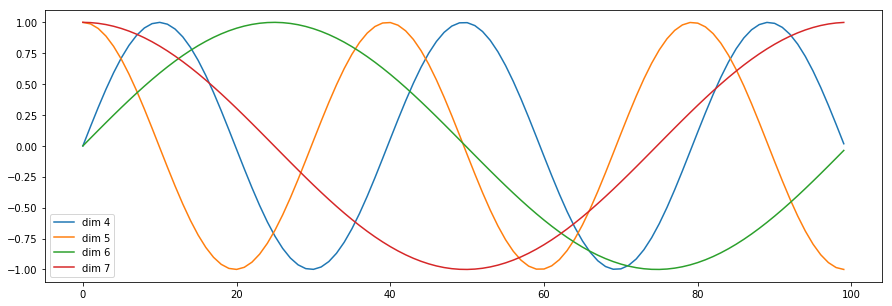

In [6]:
# 在位置编码下方，将基于位置添加正弦波。对于每个维度，波的频率和偏移都不同。
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## posembbeding的理解
- 同一维度（一个单词本来有多个维度，为了可视化，选取一个维度）对比不同位置的单词在同一维度是有相对关系的，符合某个正弦或者余弦波。
- 一个序列各个单词的位置都具有相对性。

## Training 训练方案
----
- 定义个一个Batch对象
- 

In [7]:
class Batch(object):
    "定义一个训练时需要的批次数据对象，封装了用于训练的src和tgt句子，以及mask"
    def __init__(self, src, trg=None, pad=0):
        self.src = src   # B 个序列[1,5,3, 0]
        self.src_mask = (src != pad).unsqueeze(-2) # [[1,1,1,0]]
        if trg is not None:
            self.trg = trg[:, :-1]   # 
            self.trg_y = trg[:, 1:] # 后挪一个位置开始
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [8]:
# 定义一个训练函数用于训练和计算损失、更新梯度

In [9]:
def run_epoch(data_iter, model, loss_compute, device):
    """提供训练和日志功能"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        src = batch.src.to(device)
        trg = batch.trg.to(device)
        src_mask = batch.src_mask.to(device)
        trg_mask = batch.trg_mask.to(device)
        trg_y = batch.trg_y.to(device)
        ntokens = batch.ntokens.to(device)
        
        out = model.forward(src, trg, src_mask, trg_mask)
        loss = loss_compute(out, trg_y, ntokens)
        # 必须加上.cpu().numpy() 否则报错floating point exception (core dumped)
        total_loss += loss.detach().cpu().numpy()
        total_tokens += ntokens.cpu().numpy()
        tokens += ntokens.cpu().numpy()
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss.detach().cpu().numpy() / ntokens.cpu().numpy(), tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## 训练数据与批次
- 使用XX数据集
- 使用torchtext来处理数据？

In [10]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## 硬件情况和时间表

- 我们在一台配备8个NVIDIA P100 GPU的计算机上训练了模型。
- 对于使用本文所述的超参数的基本模型，每个训练步骤大约需要0.4秒。
- 我们对基本模型进行了总共100_000步或12个小时的训练。
- 对于我们的大型模型，步长为1.0秒。大型模型接受了300,000步（3.5天）的训练。

## Optimizer
-  使用Adam优化器，其中β1= 0.9，β2= 0.98和ϵ = 10-9。
- 根据以下公式在训练过程中改变学习率：$lrate =d_{model}^{-0.5} * min（step\_num^{-0.5}, step\_num * warmup\_steps ^{-1.5}）$
- 也就是训练步数在$warmup\_steps内，线性增加学习率；之后的训练，按步数的负1.5平方成比例地减小学习率。我们使用了 $warmup\_steps= 4000$。

In [11]:
class NoamOpt(object):
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

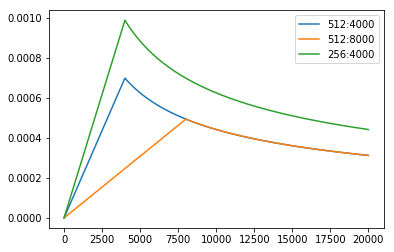

In [12]:
# 不同大小与不同超参模型的学习率曲线
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## 正如我们所分析，先线性增加，然后再逐渐减小。
---

## 正则化
### 标签平滑
- 在训练期间，我们采用ϵls = 0.1的标签平滑。随着模型训练变得更加不确定，这会增加困惑度perplexity，但会提高准确率（accuracy）和BLEU分数。
- 使用KL div损失实现标签平滑，而不是使用one-hot目标分布，我们创建的分布具有对正确单词的置信度以及其余平滑质量分布在整个词汇表中的置信度。

In [13]:
class LabelSmoothing(nn.Module):
    "实现labelsmoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

## 例子
- 

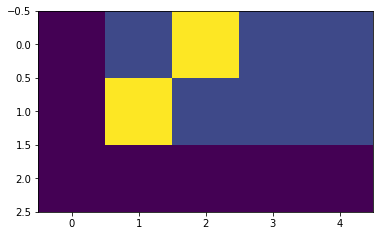

In [14]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

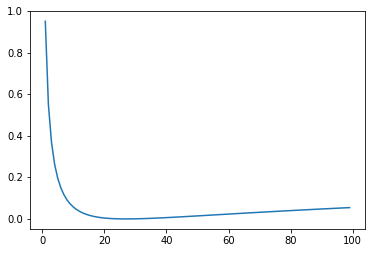

In [15]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],])
    #print(predict)
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

## 用一个小例子测试一下
- 构造数据

In [16]:
## 数据生成
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [17]:
data_gen(11, 30,20)

<generator object data_gen at 0x7f5aa03dcca8>

In [18]:
class SimpleLossCompute(object):
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss * norm.float()

In [19]:
# 贪婪解码
# Train the simple copy task.
V = 11
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.1)

model = make_model(V, V, N=2)
model = model.to(device)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [20]:
# data = torch.rand(30,20,)

In [21]:
# s1 = data[9]
# print(s1.src[5], 
#       s1.trg[5], # 
#       s1.trg_y[5], 
#       s1.src_mask.size(),
#       sep="\n")
# print(s1.trg_mask[5])
# print("ntokens", s1.ntokens)

In [22]:
mask = subsequent_mask(8)
# mask = mask.unsqueeze(1)
mask

tensor([[[1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1]]], dtype=torch.uint8)

In [23]:
score = torch.randn(1,8, 8)
score.size()

torch.Size([1, 8, 8])

In [24]:
score.masked_fill(mask == 0, -1e9)

tensor([[[-1.9573e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 6.8826e-01,  2.0662e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 6.6923e-02,  8.2864e-01,  1.0869e+00, -1.0000e+09, -1.0000e+09,
          -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 7.9477e-01,  2.0423e-01,  5.2164e-01,  7.2249e-01, -1.0000e+09,
          -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 4.8070e-01, -1.5997e+00, -2.7634e-01, -1.1522e+00, -2.1877e+00,
          -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 1.6565e+00, -1.3158e+00, -4.1631e-01,  3.1523e-01, -6.0585e-01,
          -1.4173e+00, -1.0000e+09, -1.0000e+09],
         [ 9.1306e-02, -1.9335e+00, -4.0153e-01,  5.5175e-01, -2.2587e+00,
           6.8304e-01, -6.6239e-01, -1.0000e+09],
         [-5.8243e-01,  1.4409e+00,  4.3986e-01,  3.7233e-01, -6.1916e-01,
           3.8241e-01, -9.2507e-01, -5.4309e-01]]]

In [25]:
# a = (s1.trg != 0).unsqueeze(-2) & Variable(subsequent_mask(9).type_as(s1.trg_mask.data))

In [26]:
# a.size()

In [27]:
for epoch in range(5):
    model.train()
    loss_func = SimpleLossCompute(model.generator, criterion, model_opt)
    run_epoch(data_gen(V, 30, 20), model, loss_func, device)
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                  SimpleLossCompute(model.generator, criterion, None), device))

Epoch Step: 1 Loss: 2.490279 Tokens per Sec: 1354.205838
Epoch Step: 1 Loss: 1.495896 Tokens per Sec: 6887.282458
1.424284080222801
Epoch Step: 1 Loss: 1.495560 Tokens per Sec: 5311.150413
Epoch Step: 1 Loss: 1.278627 Tokens per Sec: 6867.527062
1.2427716064453125
Epoch Step: 1 Loss: 1.482808 Tokens per Sec: 5263.556517
Epoch Step: 1 Loss: 1.123872 Tokens per Sec: 6872.569972
1.104600558810764
Epoch Step: 1 Loss: 1.792834 Tokens per Sec: 5215.222420
Epoch Step: 1 Loss: 1.022330 Tokens per Sec: 6850.080026
1.0013944272641782
Epoch Step: 1 Loss: 1.010889 Tokens per Sec: 5243.292667
Epoch Step: 1 Loss: 0.776213 Tokens per Sec: 6860.392131
0.8232519870334202


In [28]:
# https://www.cnblogs.com/shiyublog/p/10909009.html#_label5
# src = ["美中两国可能很快达成一个贸易协议。"]
# trg = ["The United States and China may soon reach a trade agreement."]

## 预测

- 最后的 linear layer 将 decoder 的输出扩展到与 vocabulary size 一样的维度上。经过 softmax 后，选择概率最高的一个 word 作为预测结果。

- 假设我们有一个已经训练好的网络，在做预测时，步骤如下：

    - 给 decoder 输入 encoder 对整个句子 embedding 的结果 和一个特殊的开始符号 </s>。decoder 将产生预测，在我们的例子中应该是 ”I”。
    - 给 decoder 输入 encoder 的 embedding 结果和 “</s>I”，在这一步 decoder 应该产生预测 “Love”。
    - 给 decoder 输入 encoder 的 embedding 结果和 “</s>I Love”，在这一步 decoder 应该产生预测 “China”。
    - 给 decoder 输入 encoder 的 embedding 结果和 “</s>I Love China”, decoder应该生成句子结尾的标记，decoder 应该输出 ”</eos>”。
然后 decoder 生成了 </eos>，翻译完成。